In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install statsmodels
!pip install pandas_datareader
!pip install datetime
!pip install yfinance
!pip install sklearn
!pip install PyPortfolioOpt
!pip install pandas_ta


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.3/247.3 kB 6.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=496bae88065bec83ede04d09f2fa1309f0f4330f3e5c6a7044570b9

In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta
import warnings
import datetime as dt
warnings.filterwarnings('ignore')

In [ ]:
sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') [0]


In [ ]:
sp500['Symbol']=sp500['Symbol'].str.replace('.','-')
sp500.drop(sp500[(sp500['Symbol'].isin(['SOLV', 'GEV']))].index,inplace=True)
symbols_list=sp500['Symbol'].unique().tolist()

In [ ]:
end_date='2024-03-31'
start_date=pd.to_datetime(end_date)-pd.DateOffset(365*8)
df=yf.download(tickers=symbols_list,start=start_date,end=end_date).stack()
df.columns=df.columns.str.lower()
df.index.names=['date','ticker']


[*********************100%%**********************]  501 of 501 completed


In [ ]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-04-04 A        37.544678   40.009998   40.520000   39.799999   40.320000   
           AAL      37.726421   39.369999   40.240002   39.150002   39.810001   
           AAPL     25.395542   27.780001   28.047501   27.567499   27.605000   
           ABBV     41.949982   59.209999   59.400002   57.490002   57.639999   
           ABT      36.484818   42.320000   42.669998   42.160000   42.340000   
...                       ...         ...         ...         ...         ...   
2024-03-28 XYL     129.240005  129.240005  130.220001  129.149994  129.559998   
           YUM     138.649994  138.649994  138.830002  137.389999  137.389999   
           ZBH     131.979996  131.979996  133.899994  131.600006  132.929993   
           ZBRA    301.440002  301.440002  302.630005  298.040009  300.239990   
           ZTS     169.210007  169.210007  171.139999  167.410004  168.729996   

Price                   volume  
date       ticker               
2016-04-04 A         2958100.0  
           AAL       7831200.0  
           AAPL    149424800.0  
           ABBV      8108100.0  
           ABT       4407800.0  
...                        ...  
2024-03-28 XYL        953200.0  
           YUM       1770900.0  
           ZBH       1425300.0  
           ZBRA       376900.0  
           ZTS       3395600.0  

[991223 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [ ]:
df['garman_klass_vol']=((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*(np.log(df['adj close'])-np.log(df['open']))**2

## RSI
The relative strength index (RSI) is a momentum indicator used in technical analysis. RSI measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security.


In [ ]:
df['rsi']=df.groupby(level=1)['adj close'].transform(lambda x:pandas_ta.rsi(close=x,length=20) )

<Axes: xlabel='date'>

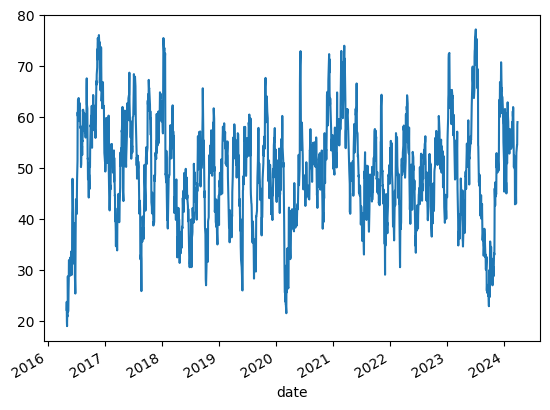

In [ ]:
# xs is used to get cross section of a specific label at some level of multi-index dataframe
df.xs('AAL',level=1)['rsi'].plot()

## Bollinger Bands
 Bollinger Bands are envelopes plotted at a standard deviation level above and below a simple moving average of the price. Because the distance of the bands is based on standard deviation, they adjust to volatility swings in the underlying price.

In [ ]:
df['bb_low']=df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(np.log1p(x),20).iloc[:,0])
df['bb_mid']=df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(np.log1p(x),20).iloc[:,1])
df['bb_high']=df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(np.log1p(x),20).iloc[:,2])

## ATR
The average true range (ATR) is a technical analysis indicator introduced by market technician J. Welles Wilder Jr. in his book New Concepts in Technical Trading Systems that measures market volatility by decomposing the entire range of an asset price for that period.

The true range indicator is taken as the greatest of the following: current high less the current low; the absolute value of the current high less the previous close; and the absolute value of the current low less the previous close. The ATR is then a moving average, generally using 14 days, of the true ranges

In [ ]:
def compute_atr(stock_data):
  atr=pandas_ta.atr(high=stock_data['high'],low=stock_data['low'],close=stock_data['close'],length=14)
  return atr.sub(atr.mean()).div(atr.std())
df['atr']=df.groupby(level=1,group_keys=False).apply(compute_atr)

## MACD
The MACD line is calculated by subtracting the 26-period EMA from the 12-period EMA. The calculation creates the MACD line. A nine-day EMA of the MACD line is called the signal line, plotted on top of the MACD line, which can function as a trigger for buy or sell signals.

In [ ]:
def compute_macd(close):
  macd=pandas_ta.macd(close=close,length=20)
  return macd.sub(macd.mean()).div(macd.std()).iloc[:,0]
df['macd']=df.groupby(level=1,group_keys=False)['adj close'].apply(compute_macd)


In [ ]:
df['dollar_volume']=(df['adj close']*df['volume'])/1e6

Now we aggregate it to monthly level instead of daily bases

In [ ]:
# we can use sample to convert the time series to month
# we will be using following technical indicators as features
last_cols=[c for c in df.columns.unique(0) if c not in ['dollar_volume','close','volume','open','high','low']]
data=pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1).dropna()

Now we calculate rolling mean for 5 years for dollar volume

In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

In [ ]:
data['dollar_vol_rank']=data.groupby('date')['dollar_volume'].rank(ascending=False)

In [ ]:
data=data[data['dollar_vol_rank']<150].drop(['dollar_volume','dollar_vol_rank'],axis=1)

Now we calculate monthly returns for various time horizons i.e. time gaps for example 3 months, 6 months identified by lag

In [ ]:
def calculate_returns(g):
  outlier_cutoff=0.005
  lags=[1,2,3,6,9,12]
  for lag in lags:
    #pipe: Apply chainable functions that expect Series or DataFrames.
    #pct_change: Fractional change between the current and a prior element.
    g[f'return_{lag}m']=g['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)).add(1).pow(1/lag).sub(1))
  return g;
data=data.groupby(level=1,group_keys=False).apply(calculate_returns).dropna()


In [ ]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-04-30 AAL      41.922886  2.133559  3.961549  3.733074  3.847312   
           AAPL     39.177345 -0.818114  3.777232  3.663645  3.720439   
           ABBV     74.159805  0.982471  4.331109  4.229163  4.280136   
           ABT      52.741100 -0.565441  4.019137  3.974422  3.996780   
           ACN     138.647720 -0.516886  4.969163  4.904240  4.936702   
...                       ...       ...       ...       ...       ...   
2024-03-31 VRTX    418.010010  0.563942  6.056774  6.005554  6.031164   
           VZ       41.291332 -0.693024  3.734437  3.675142  3.704789   
           WFC      57.959999 -0.341665  4.086067  4.038277  4.062172   
           WMT      60.169998  0.169386  4.141587  4.095753  4.118670   
           XOM     116.239998 -0.052811  4.776569  4.653202  4.714886   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-04-30 AAL            -0.000233 -2.451371  34.064589  -0.173788   
           AAPL            0.000096 -0.519764  44.093201  -0.015020   
           ABBV           -0.031915 -0.927850  47.693796   0.030640   
           ABT            -0.005614 -0.418465  45.310112  -0.025203   
           ACN            -0.003740 -0.329596  47.986205  -0.006291   
...                             ...       ...        ...        ...   
2024-03-31 VRTX            0.000085 -0.586921  50.803478  -0.006489   
           VZ              0.000050  0.561110  64.018258   0.048476   
           WFC             0.000030  1.296821  67.497281   0.042634   
           WMT             0.000025  1.279481  58.957218   0.030113   
           XOM             0.000058  2.267394  73.762481   0.112132   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-04-30 AAL     -0.110429  -0.074851  -0.013677  -0.017083    0.001295  
           AAPL    -0.036775  -0.002988  -0.002490   0.013081    0.013071  
           ABBV    -0.082295  -0.045625   0.014256   0.039338    0.035160  
           ABT     -0.016043  -0.020529   0.013257   0.020388    0.025886  
           ACN     -0.026676  -0.017233   0.011571   0.020044    0.020096  
...                      ...        ...        ...        ...         ...  
2024-03-31 VRTX    -0.017893   0.009028   0.031150   0.019310    0.023839  
           VZ      -0.004615   0.042123   0.048024   0.019778    0.012408  
           WFC      0.078496   0.058463   0.062806   0.037311    0.039950  
           WMT      0.046931   0.047357   0.021589   0.016699    0.018226  
           XOM      0.068240   0.054759   0.001149   0.011961    0.007816  

[10359 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [ ]:
# fama french factors will be downloaded using library pandas_datareader
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)
# Now since our data is in yyyy/mm/dd format but this is in yyyy/mm format we need to convert it to the same
# for this we will use timestamp
factor_data.index=factor_data.index.to_timestamp()
#Now initially we have end of month dates. But here is start date so we will resample it
factor_data=factor_data.resample('M').last()
#Alse this data is in percentage but we need it in fraction so
factor_data=factor_data.div(100)
# Now we need to join this factor_data with one month return
factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-04-30 AAL     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.173788
           AAPL    0.0028  0.0093  0.0054 -0.0242  0.0130  -0.015020
           ABBV    0.0028  0.0093  0.0054 -0.0242  0.0130   0.030640
           ABT     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.025203
           ACN     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.006291
...                   ...     ...     ...     ...     ...        ...
2024-02-29 VRTX    0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.029166
           VZ      0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.055018
           WFC     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.115593
           WMT     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.064024
           XOM     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.026081

[10216 rows x 6 columns]

In [ ]:
factor_data.xs('AAPL',level=1).head(5)

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date                                                         
2018-04-30  0.0028  0.0093  0.0054 -0.0242  0.0130  -0.015020
2018-05-31  0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.135124
2018-06-30  0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
2018-07-31  0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
2018-08-31  0.0344  0.0064 -0.0394 -0.0031 -0.0270   0.200422

In [ ]:
factor_data.xs('MSFT',level=1).head(5)

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date                                                         
2018-04-30  0.0028  0.0093  0.0054 -0.0242  0.0130   0.024652
2018-05-31  0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.061467
2018-06-30  0.0048  0.0080 -0.0234  0.0079  0.0024  -0.002327
2018-07-31  0.0319 -0.0193  0.0047  0.0156  0.0035   0.075753
2018-08-31  0.0344  0.0064 -0.0394 -0.0031 -0.0270   0.062993

We need to remove stocks which have data less than 10 months

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-04-30 AAL     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.173788
           AAPL    0.0028  0.0093  0.0054 -0.0242  0.0130  -0.015020
           ABBV    0.0028  0.0093  0.0054 -0.0242  0.0130   0.030640
           ABT     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.025203
           ACN     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.006291
...                   ...     ...     ...     ...     ...        ...
2024-02-29 VRTX    0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.029166
           VZ      0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.055018
           WFC     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.115593
           WMT     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.064024
           XOM     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.026081

[10180 rows x 6 columns]

Now we need to calculate rolling factor betas

The ordinary least squares (OLS) algorithm is a method for estimating the parameters of a linear regression model. The OLS algorithm aims to find the values of the linear regression model’s parameters (i.e., the coefficients) that minimize the sum of the squared residuals. The residuals are the differences between the observed values of the dependent variable and the predicted values of the dependent variable given the independent variables.

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-04-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-02-29 VRTX    0.326829  0.592502 -0.880360  0.213540  1.148968
           VZ      0.465167 -1.123804  0.786202  0.143398 -0.493900
           WFC     1.130585  0.277844  1.569917 -0.359533 -1.258981
           WMT     0.551393  0.245397 -0.959633  0.587579  0.954846
           XOM     0.813154 -0.008881  0.464561  0.828060  0.579910

[10180 rows x 5 columns]

Now since we calculate 1 month return from previous month data, we can't join this data normally. So we will have to shift it by one

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10198 entries, (Timestamp('2018-04-30 00:00:00'), 'AAL') to (Timestamp('2024-03-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10198 non-null  float64
 1   bb_high           10198 non-null  float64
 2   bb_low            10198 non-null  float64
 3   bb_mid            10198 non-null  float64
 4   garman_klass_vol  10198 non-null  float64
 5   macd              10198 non-null  float64
 6   rsi               10198 non-null  float64
 7   return_1m         10198 non-null  float64
 8   return_2m         10198 non-null  float64
 9   return_3m         10198 non-null  float64
 10  return_6m         10198 non-null  float64
 11  return_9m         10198 non-null  float64
 12  return_12m        10198 non-null  float64
 13  Mkt-RF            10198 non-null  float64
 14  SMB               10198 non-null  float64
 15  HML        

Now we will cluster this stocks together each month into 4 clusters

Now for making the trades. Lets say we take stocks which have high rsi i.e. where rsi is near 70. So lets form clusters in similar manner

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [ ]:
from sklearn.cluster import KMeans
# data.drop(['cluster'],axis=1,inplace=True)
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-04-30 AAL     2.133559  3.961549  3.733074  3.847312         -0.000233   
           AAPL   -0.818114  3.777232  3.663645  3.720439          0.000096   
           ABBV    0.982471  4.331109  4.229163  4.280136         -0.031915   
           ABT    -0.565441  4.019137  3.974422  3.996780         -0.005614   
           ACN    -0.516886  4.969163  4.904240  4.936702         -0.003740   
...                     ...       ...       ...       ...               ...   
2024-03-31 VRTX    0.563942  6.056774  6.005554  6.031164          0.000085   
           VZ     -0.693024  3.734437  3.675142  3.704789          0.000050   
           WFC    -0.341665  4.086067  4.038277  4.062172          0.000030   
           WMT     0.169386  4.141587  4.095753  4.118670          0.000025   
           XOM    -0.052811  4.776569  4.653202  4.714886          0.000058   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-04-30 AAL    -2.451371  34.064589  -0.173788  -0.110429  -0.074851   
           AAPL   -0.519764  44.093201  -0.015020  -0.036775  -0.002988   
           ABBV   -0.927850  47.693796   0.030640  -0.082295  -0.045625   
           ABT    -0.418465  45.310112  -0.025203  -0.016043  -0.020529   
           ACN    -0.329596  47.986205  -0.006291  -0.026676  -0.017233   
...                     ...        ...        ...        ...        ...   
2024-03-31 VRTX   -0.586921  50.803478  -0.006489  -0.017893   0.009028   
           VZ      0.561110  64.018258   0.048476  -0.004615   0.042123   
           WFC     1.296821  67.497281   0.042634   0.078496   0.058463   
           WMT     1.279481  58.957218   0.030113   0.046931   0.047357   
           XOM     2.267394  73.762481   0.112132   0.068240   0.054759   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-04-30 AAL     -0.013677  -0.017083    0.001295  1.235900  1.410526   
           AAPL    -0.002490   0.013081    0.013071  1.323462 -0.361471   
           ABBV     0.014256   0.039338    0.035160  0.456440  0.554796   
           ABT      0.013257   0.020388    0.025886  0.807434 -0.145252   
           ACN      0.011571   0.020044    0.020096  1.221949 -0.177676   
...                      ...        ...         ...       ...       ...   
2024-03-31 VRTX     0.031150   0.019310    0.023839  0.513459  0.005223   
           VZ       0.048024   0.019778    0.012408  0.474466 -0.398802   
           WFC      0.062806   0.037311    0.039950  1.066638 -0.078573   
           WMT      0.021589   0.016699    0.018226  0.602102 -0.413934   
           XOM      0.001149   0.011961    0.007816  1.099402  0.211395   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-04-30 AAL     0.485002  0.136368  0.795778        0  
           AAPL   -0.620854  0.463613  0.619539        1  
           ABBV   -0.170330  0.516956  0.383818        1  
           ABT    -0.479459  0.278422  0.966953        1  
           ACN    -0.279906  0.316983  0.140965        1  
...                     ...       ...       ...      ...  
2024-03-31 VRTX   -0.877978  0.134600  0.858134        1  
           VZ      0.162797  0.254393  0.329778        2  
           WFC     1.536677 -0.743297 -0.771876        3  
           WMT    -0.351972  0.274737  0.690452        2  
           XOM     0.777689 -0.472596  0.524179        3  

[10198 rows x 19 columns]

Now lets visualise these clusters. Lets put this on scatter plot for each month on rsi and atr

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return


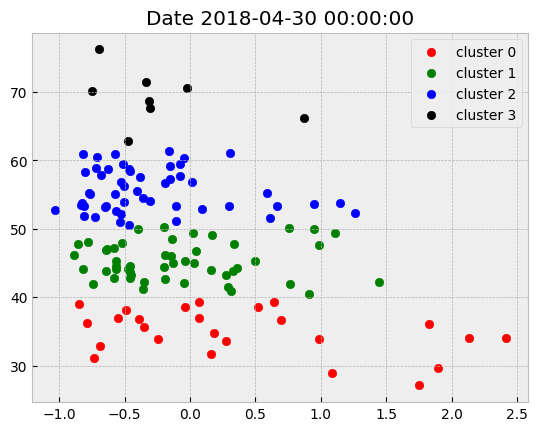

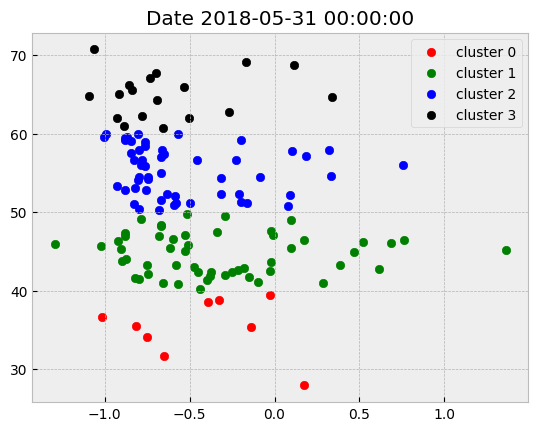

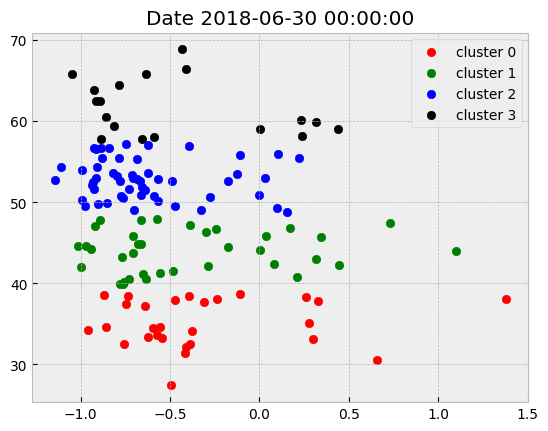

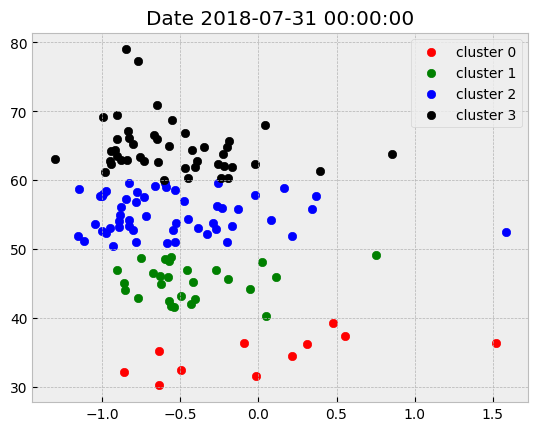

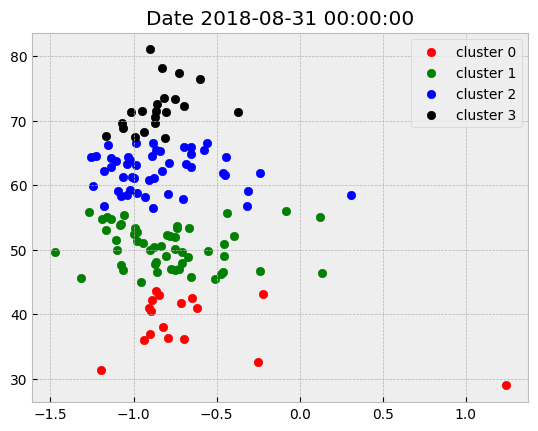

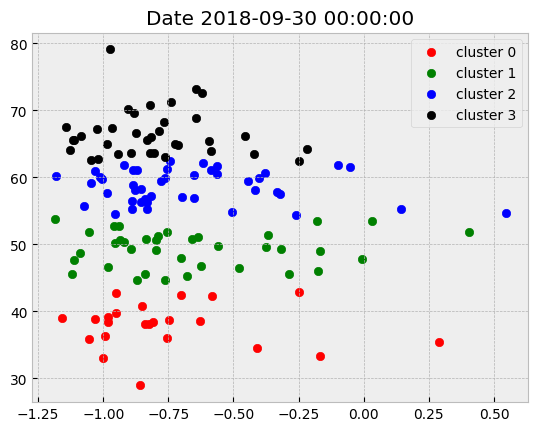

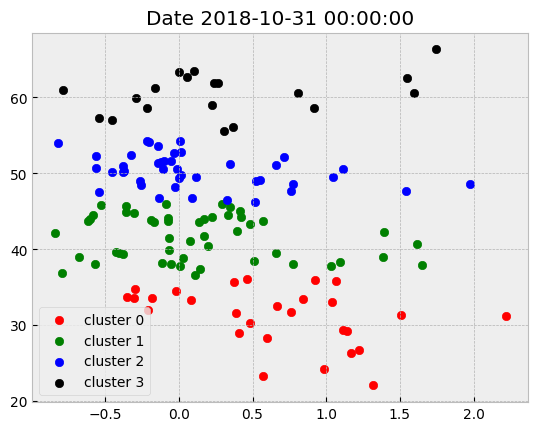

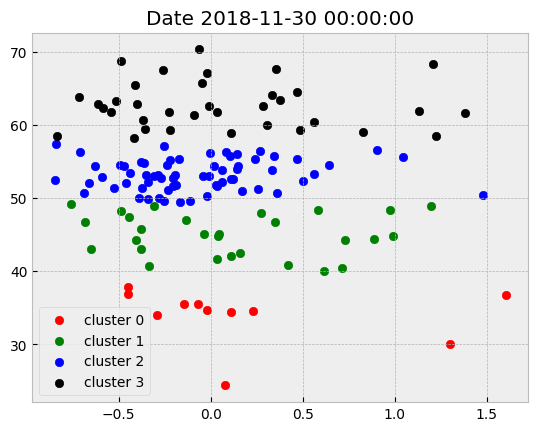

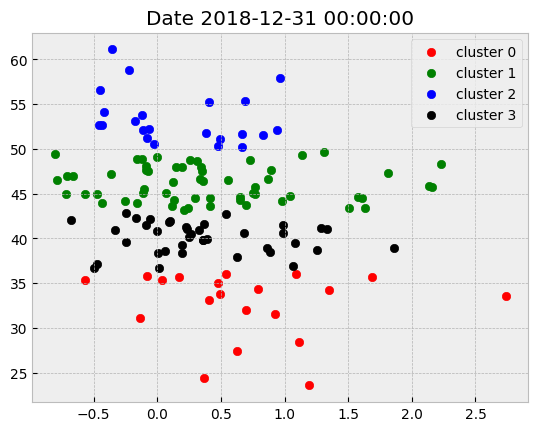

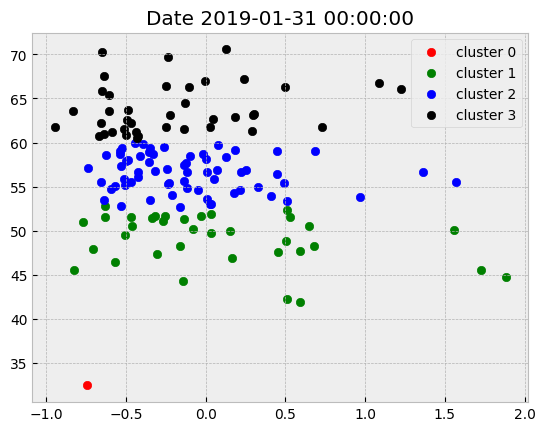

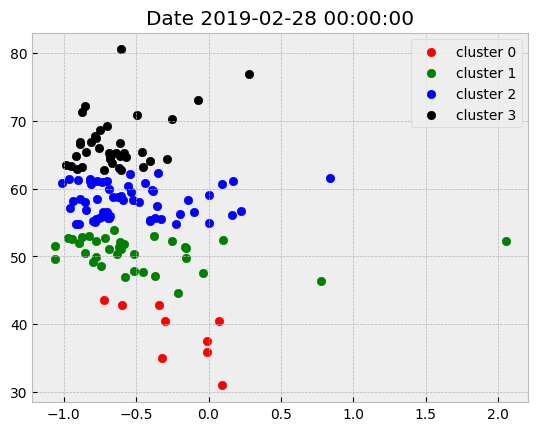

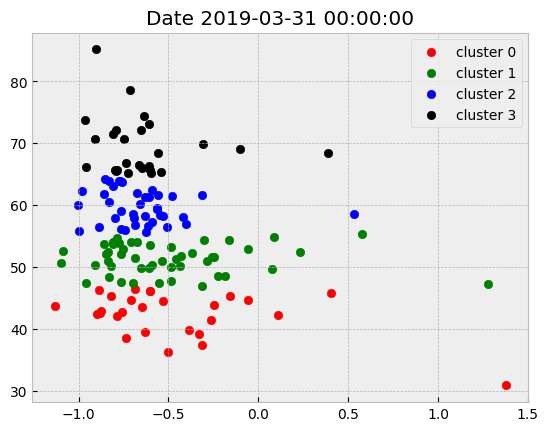

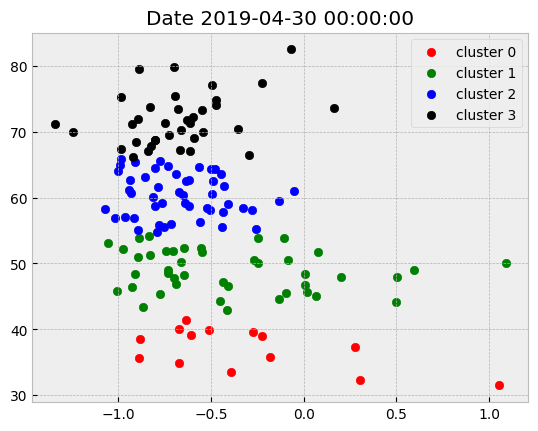

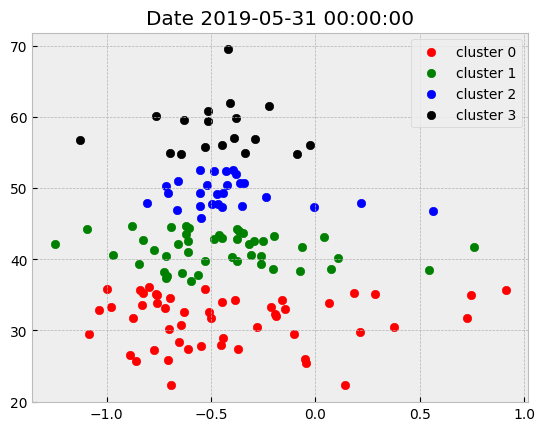

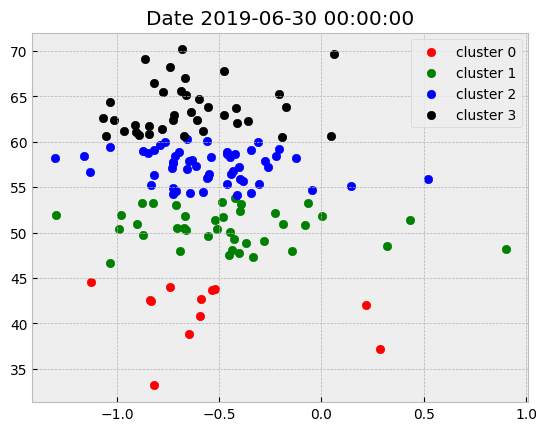

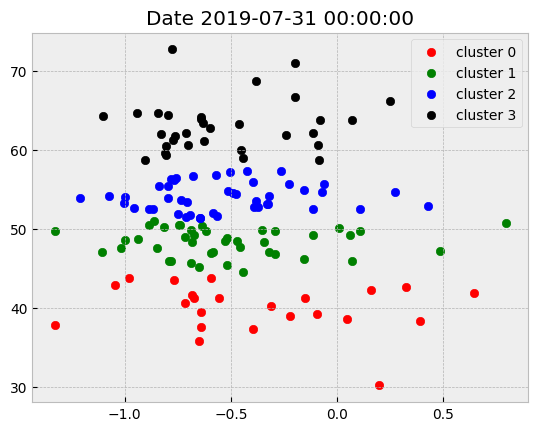

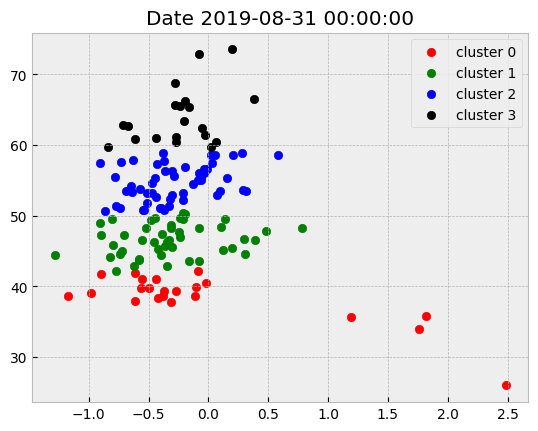

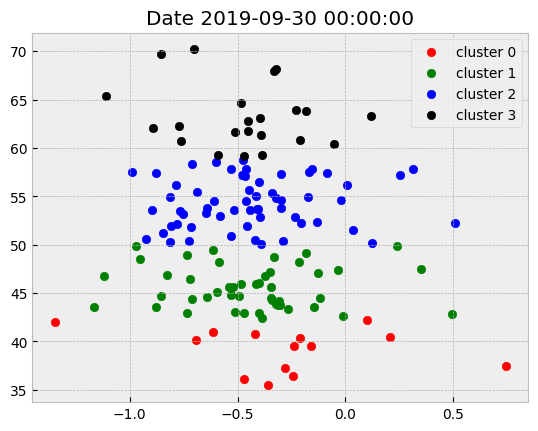

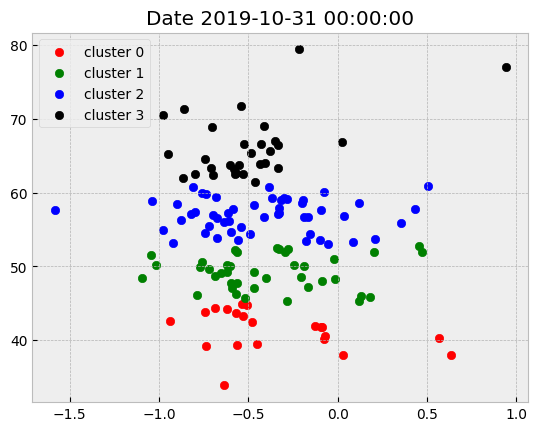

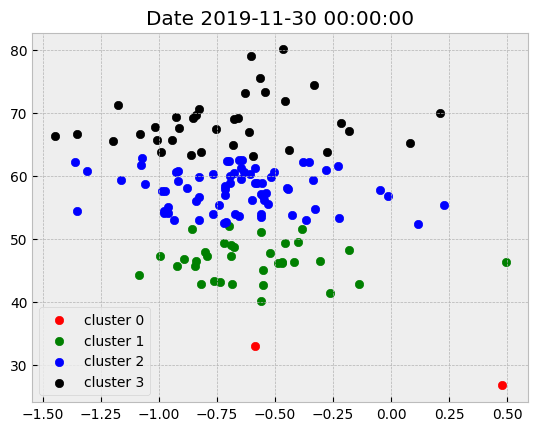

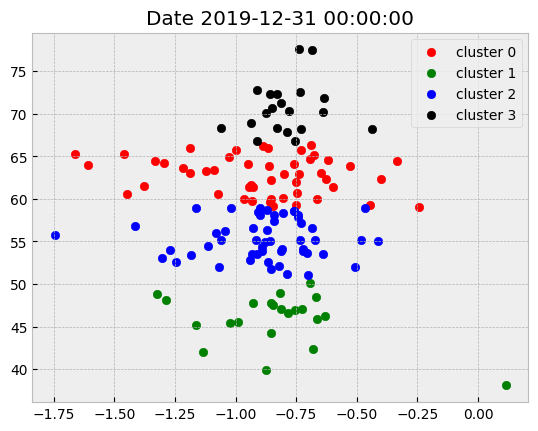

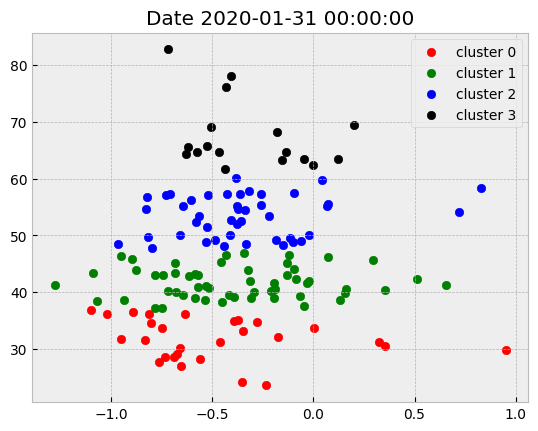

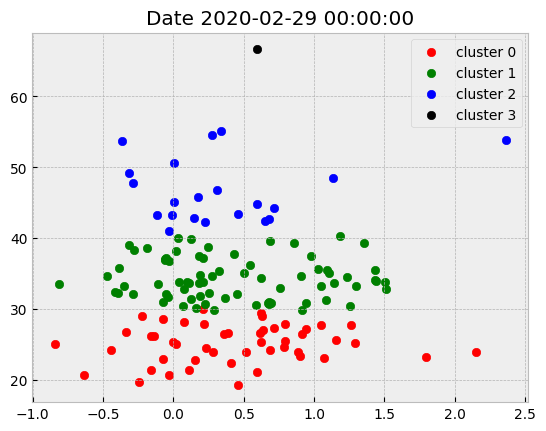

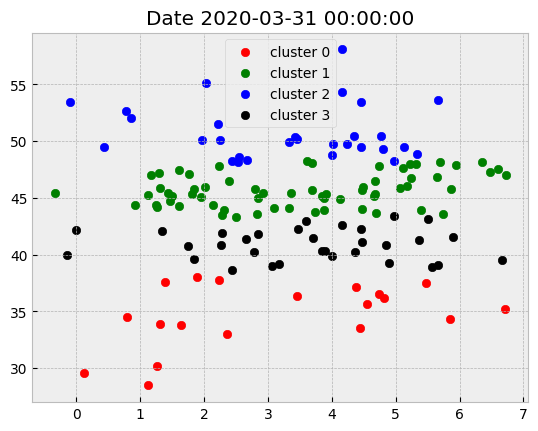

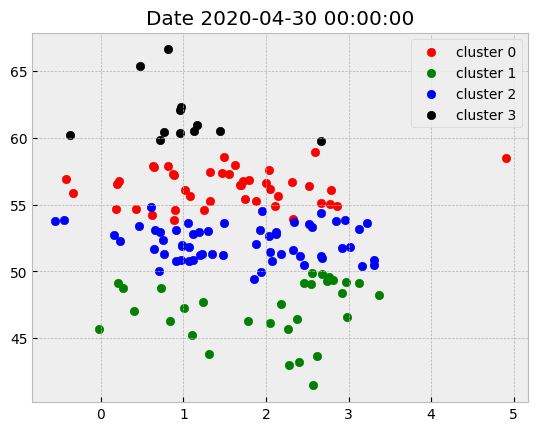

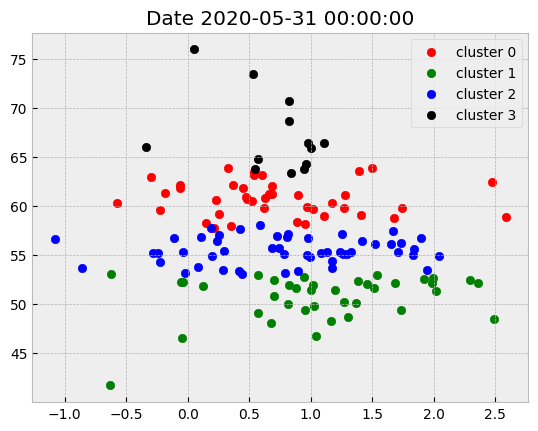

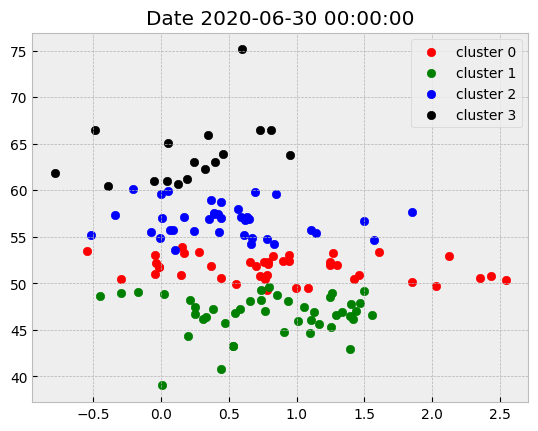

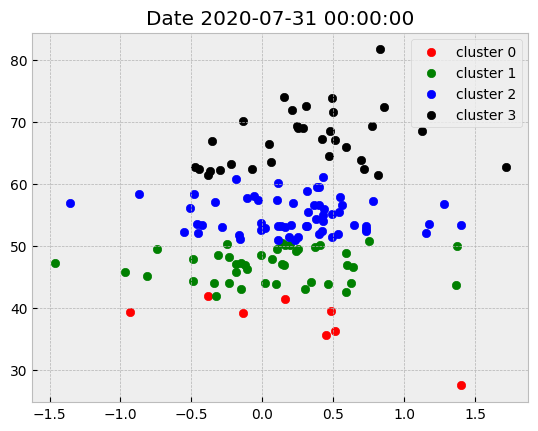

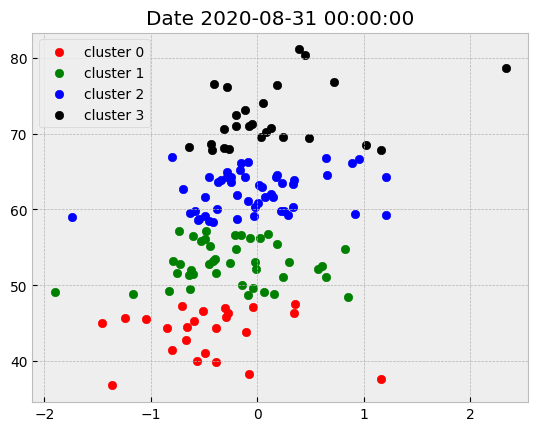

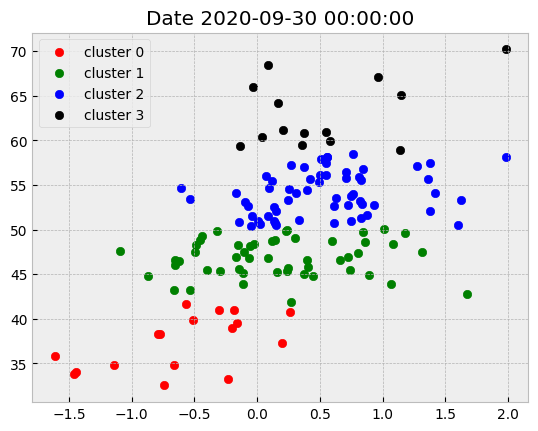

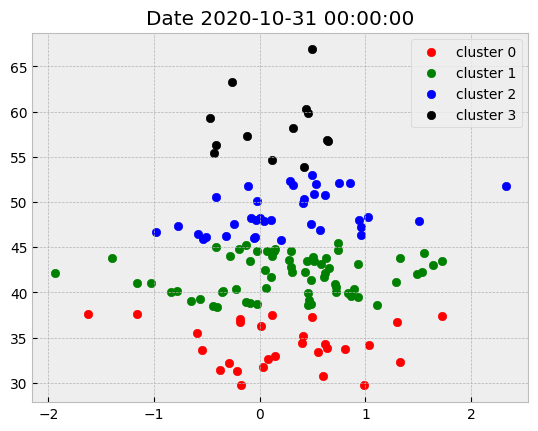

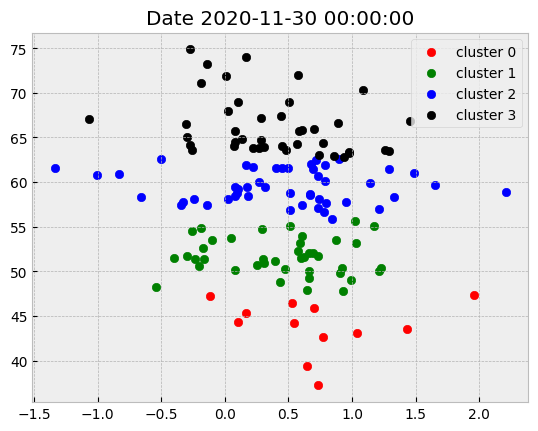

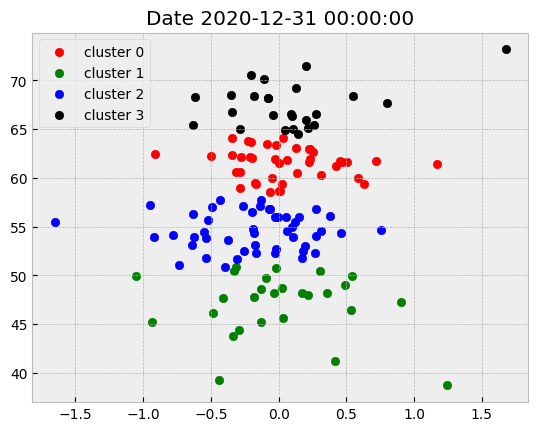

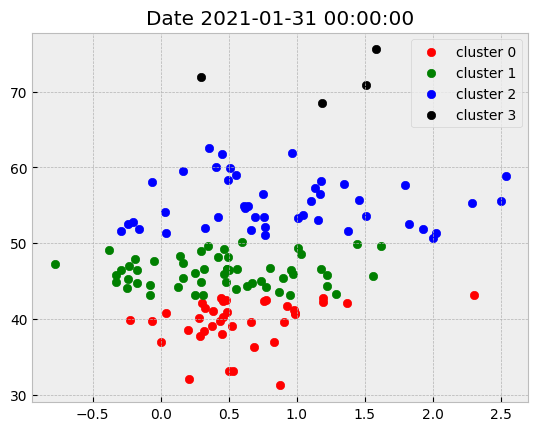

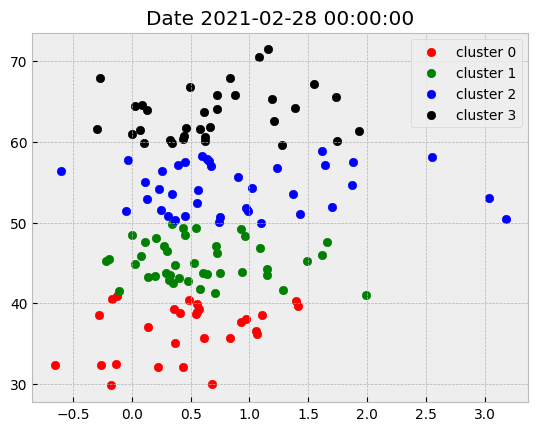

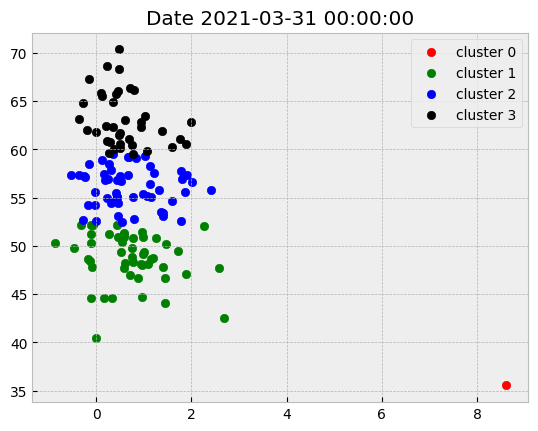

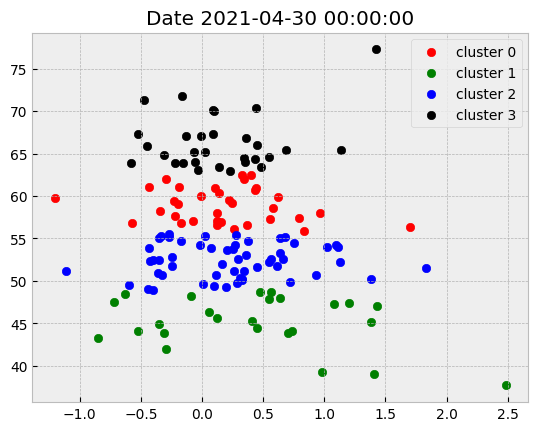

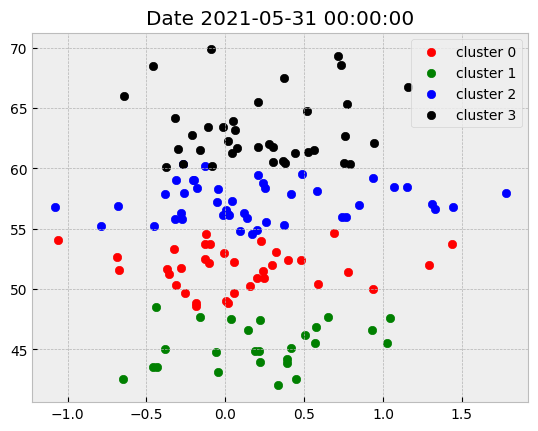

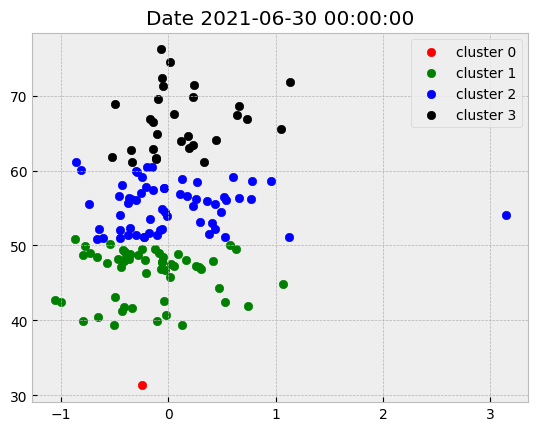

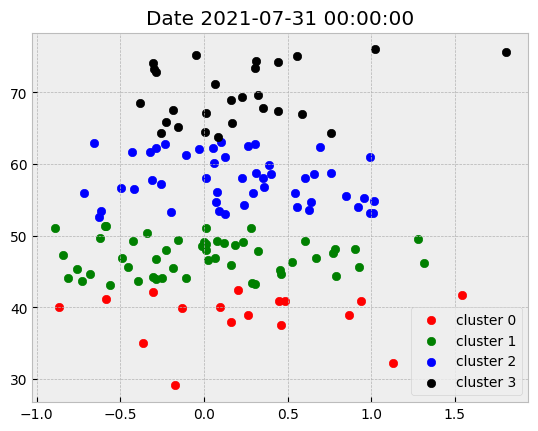

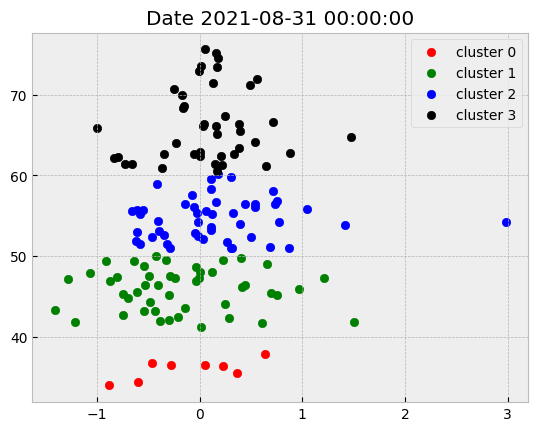

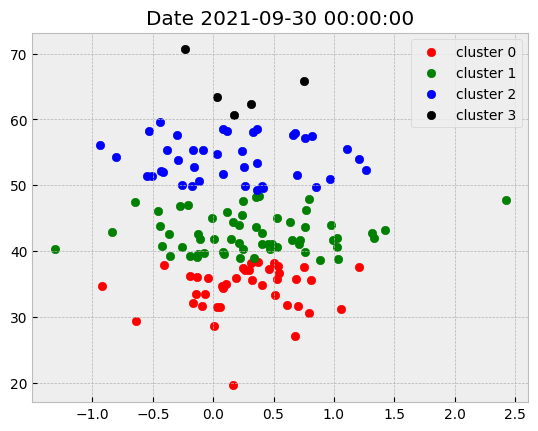

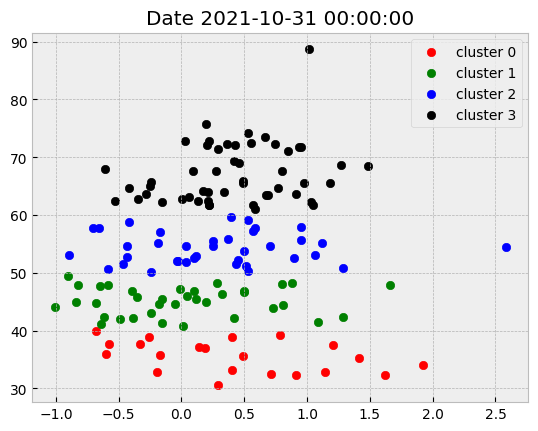

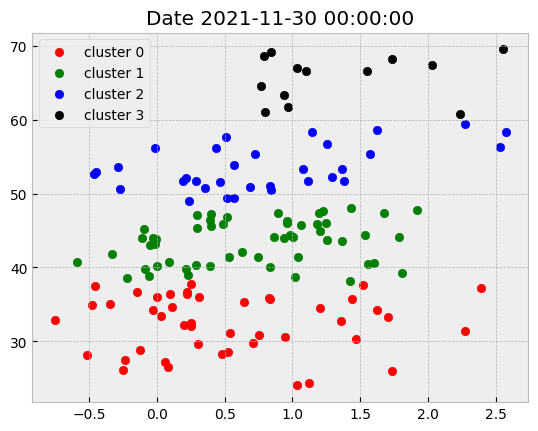

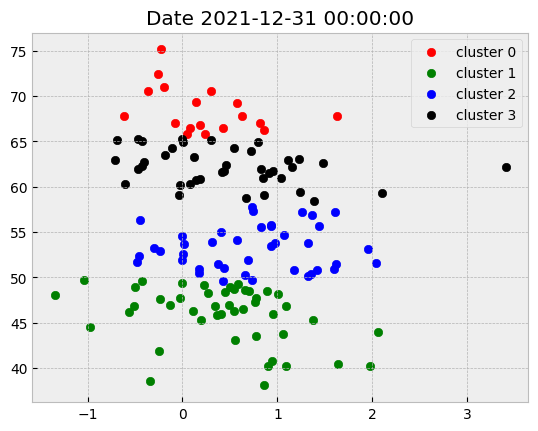

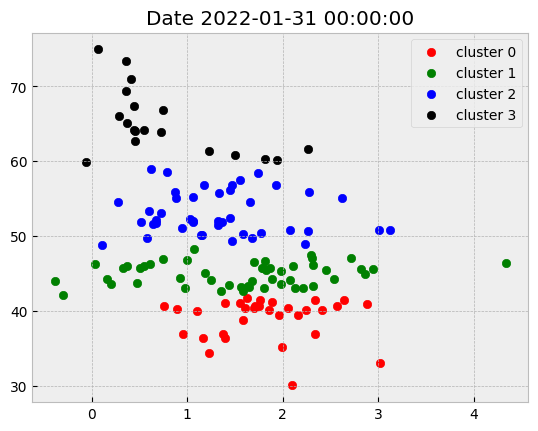

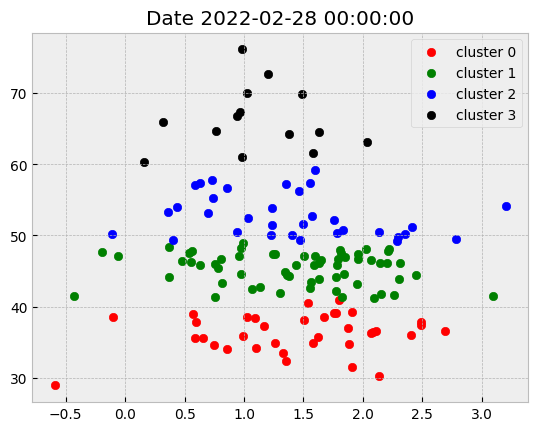

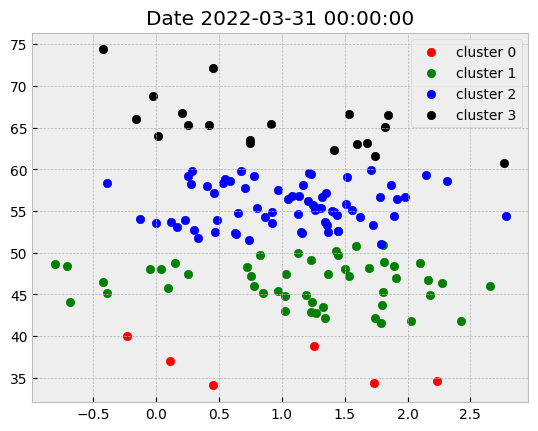

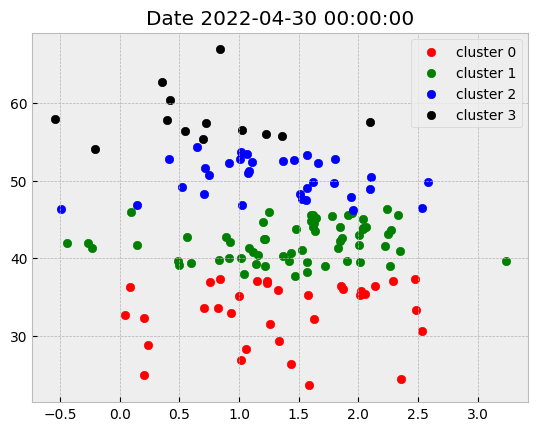

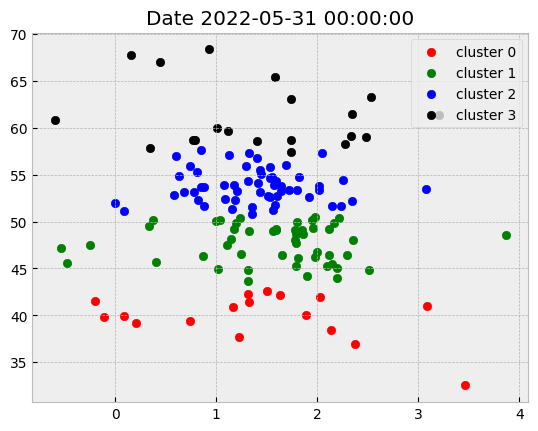

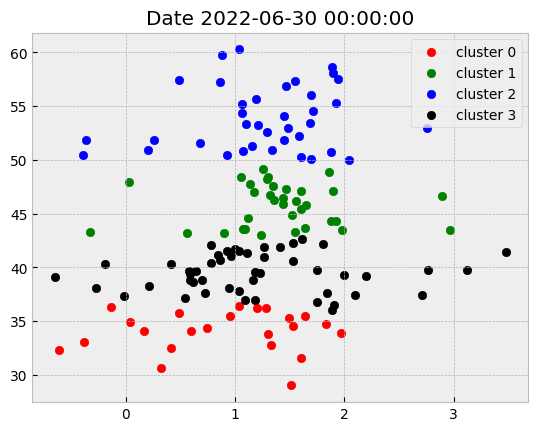

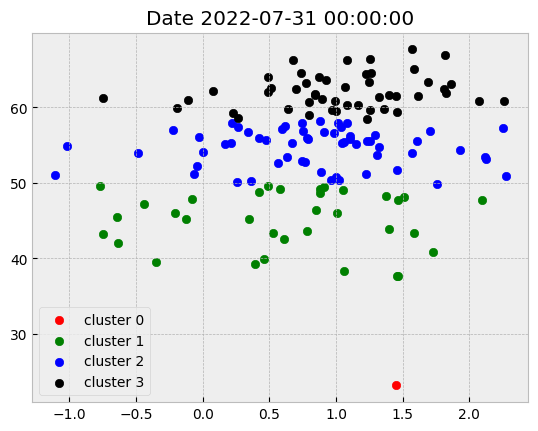

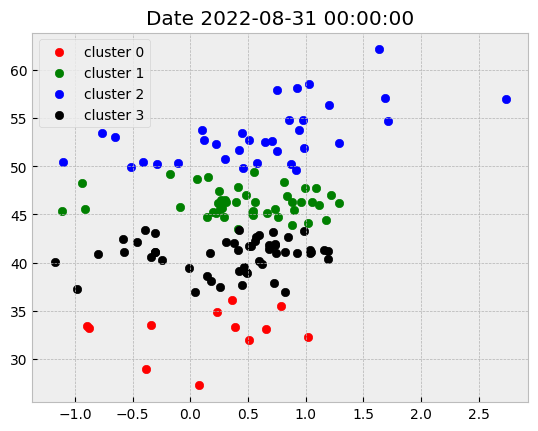

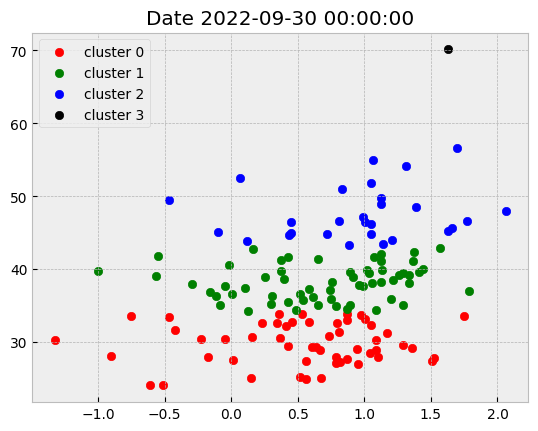

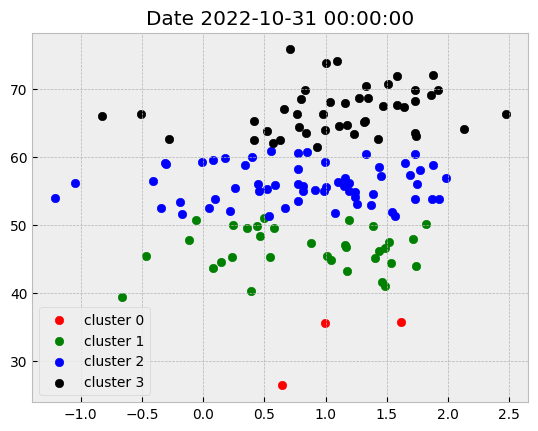

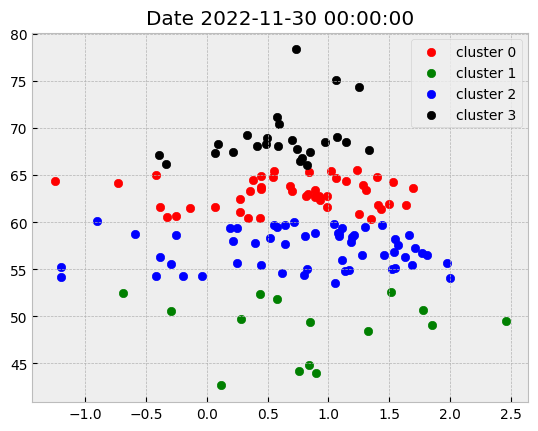

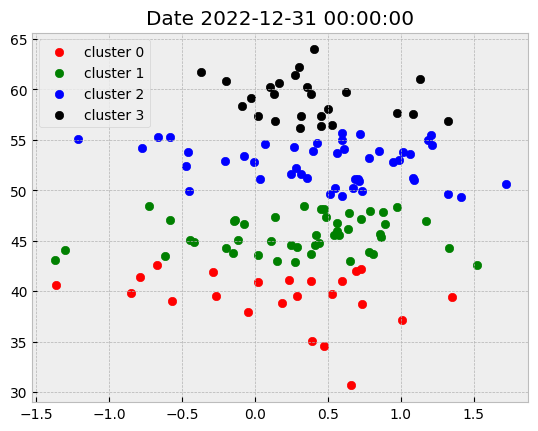

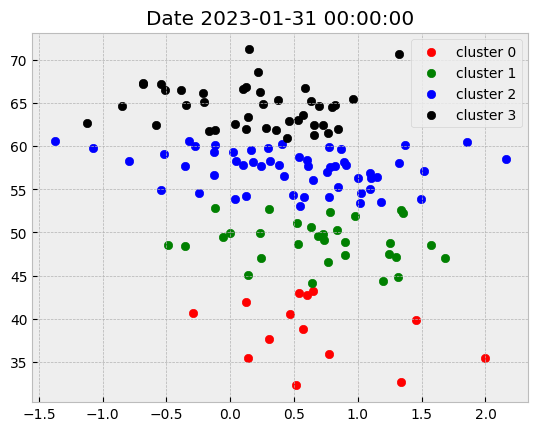

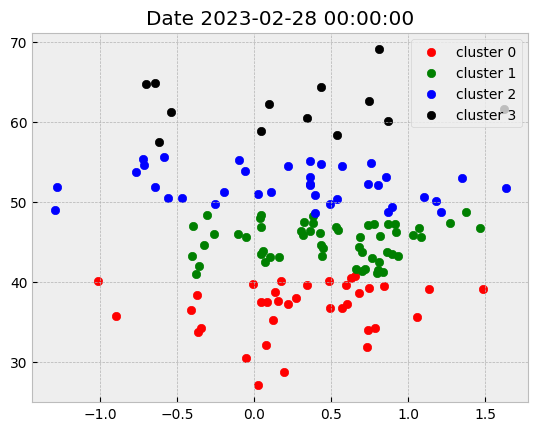

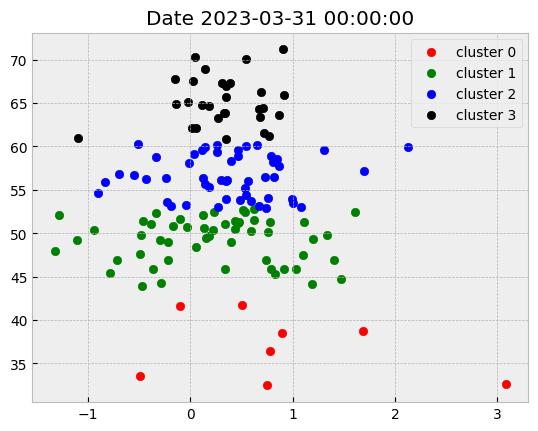

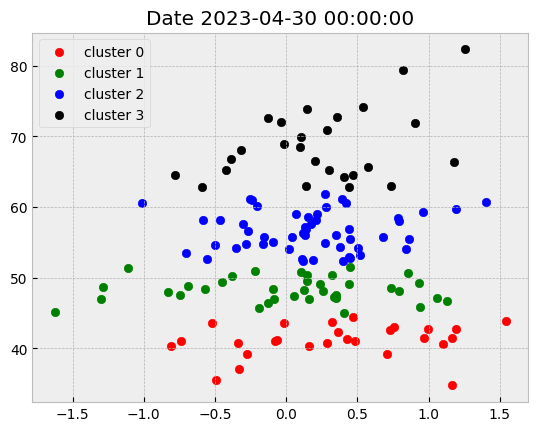

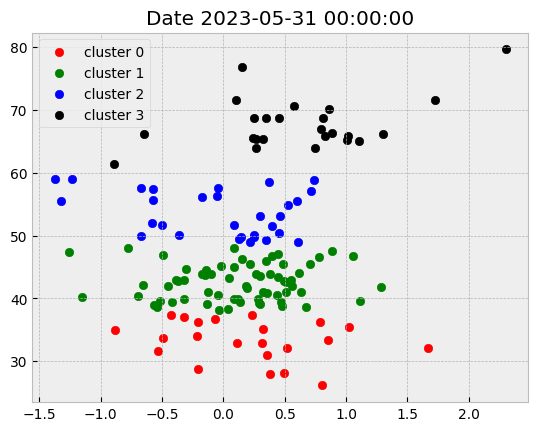

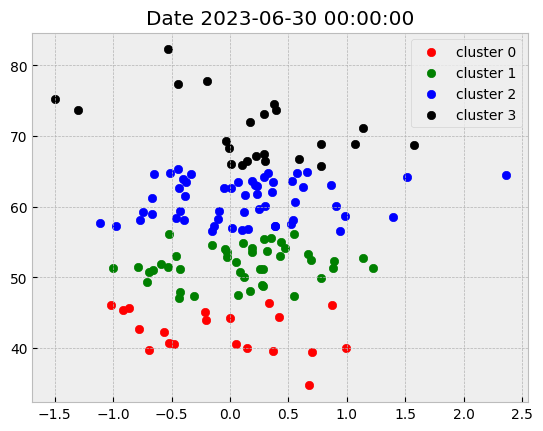

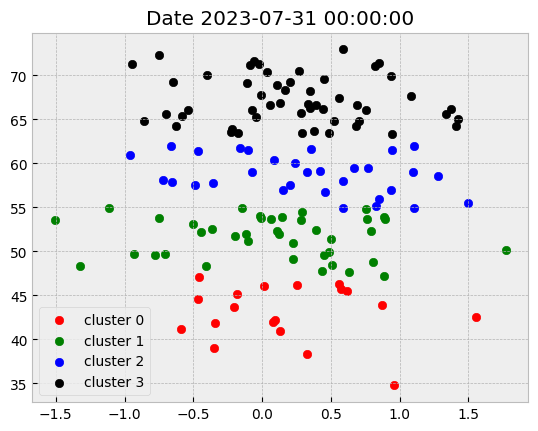

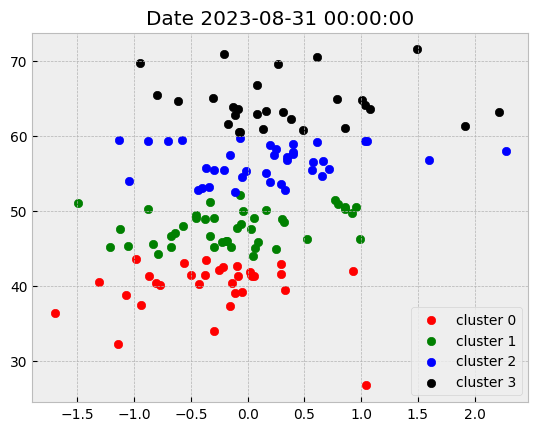

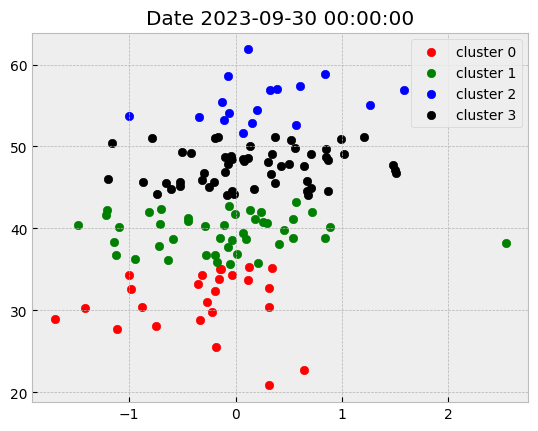

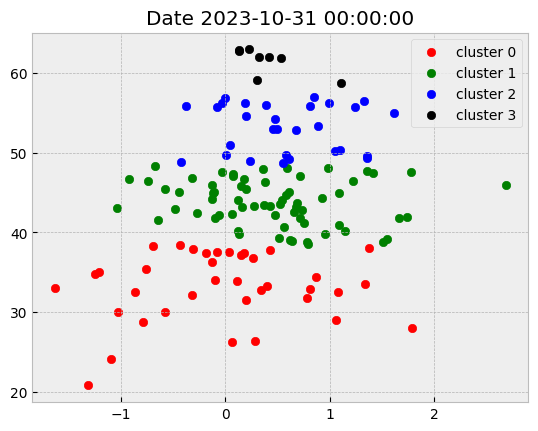

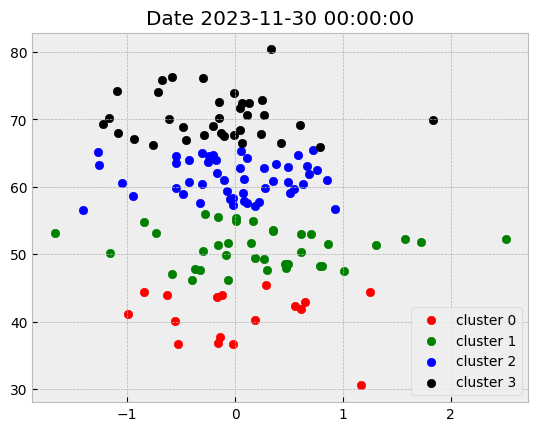

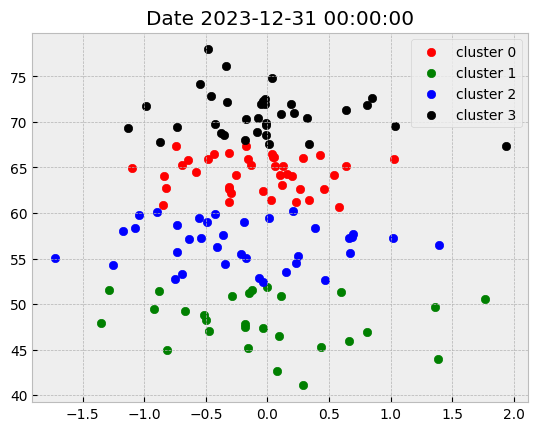

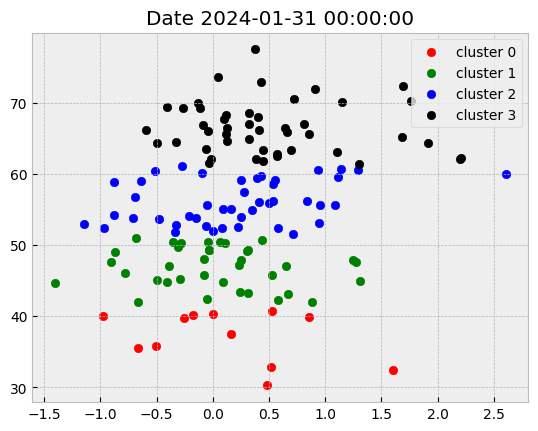

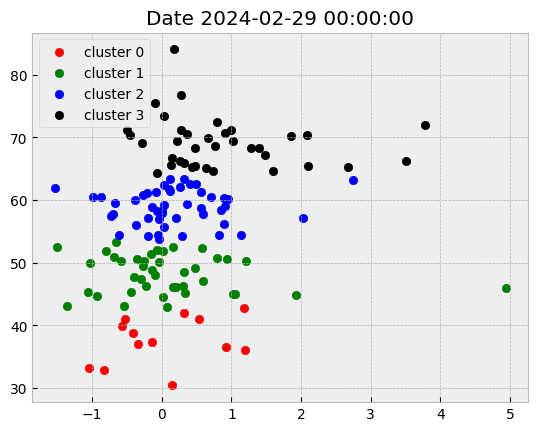

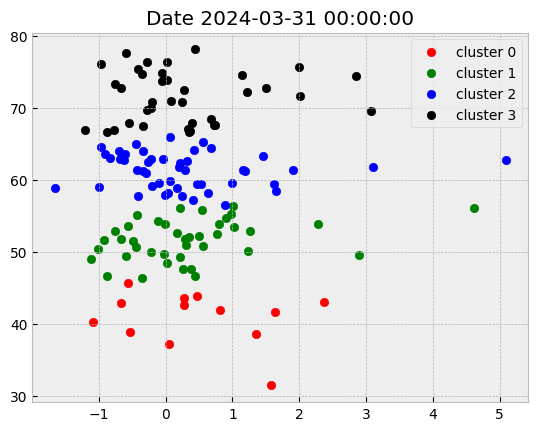

In [ ]:
plt.style.use('bmh')
for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus select stocks corresponding to cluster 3.

In [ ]:
data[data['cluster']==3]

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-04-30 CMG    -0.696339  6.022758  5.643138  5.832948          0.000405   
           COP    -0.472684  4.054310  3.897323  3.975816         -0.013705   
           EOG    -0.305413  4.575805  4.397182  4.486493         -0.017964   
           HAL     0.867753  3.913205  3.742239  3.827722         -0.003833   
           OXY    -0.335149  4.263781  4.048483  4.156132         -0.008598   
...                     ...       ...       ...       ...               ...   
2024-03-31 SLB    -1.201486  4.052001  3.906494  3.979248          0.000120   
           TGT     0.242532  5.203263  5.056539  5.129901          0.000058   
           VLO     1.137870  5.201465  4.942463  5.071964          0.000389   
           WFC    -0.341665  4.086067  4.038277  4.062172          0.000030   
           XOM    -0.052811  4.776569  4.653202  4.714886          0.000058   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-04-30 CMG     0.452834  76.233004   0.310173   0.153045   0.092376   
           COP     0.890474  62.841843   0.104739   0.098198   0.038422   
           EOG     1.219107  67.726442   0.124434   0.080332   0.009672   
           HAL     1.406074  66.123464   0.128888   0.070511  -0.003132   
           OXY     1.860637  71.424662   0.189348   0.091706   0.014088   
...                     ...        ...        ...        ...        ...   
2024-03-31 SLB     1.311187  66.977921   0.134078   0.063895   0.019365   
           TGT     1.706209  70.920376   0.158841   0.132959   0.078220   
           VLO     3.133908  74.615701   0.206631   0.108544   0.097785   
           WFC     1.296821  67.497281   0.042634   0.078496   0.058463   
           XOM     2.267394  73.762481   0.112132   0.068240   0.054759   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-04-30 CMG      0.076577   0.023401   -0.009459  1.248288  0.108842   
           COP      0.043008   0.042883    0.028318  1.406580  0.193648   
           EOG      0.028977   0.024934    0.021192  1.508621 -0.002299   
           HAL      0.037866   0.026418    0.013483  2.475937  0.741116   
           OXY      0.034320   0.028937    0.023220  1.899863  0.449731   
...                      ...        ...         ...       ...       ...   
2024-03-31 SLB     -0.008502   0.013904    0.010901  1.756496  0.347449   
           TGT      0.084980   0.036369    0.008414  0.896027  0.502928   
           VLO      0.034191   0.045298    0.019681  2.221004  0.652640   
           WFC      0.062806   0.037311    0.039950  1.066638 -0.078573   
           XOM      0.001149   0.011961    0.007816  1.099402  0.211395   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-04-30 CMG    -0.910845  0.245990  0.468740        3  
           COP     1.078657 -0.902039  0.543332        3  
           EOG     1.626547 -0.897885  0.626183        3  
           HAL     0.686426 -0.327033  0.772468        3  
           OXY     0.821175 -2.569844  1.886162        3  
...                     ...       ...       ...      ...  
2024-03-31 SLB     1.375588 -1.130372  0.485108        3  
           TGT    -0.540221  0.967579  0.434659        3  
           VLO     0.377765  0.940036  2.873379        3  
           WFC     1.536677 -0.743297 -0.771876        3  
           XOM     0.777689 -0.472596  0.524179        3  

[2003 rows x 19 columns]

In [ ]:
filtered_df = data[data['cluster']==3].copy()
# Now since we use this values for the start of next month, lets add to date by 1
filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()
# it will return the list of stocks to buy for each month
fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX',
  'VZ'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BMY',
  'C',
  'CL',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'KR',
  'LLY',
  'LMT',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ADP',
  'AMD',
  'AMZN',
  'BDX',
  'COST',
  'CSCO',
  'CVS',
  'DAL',
  'ISRG',
  'LLY',
  'LOW',
  'MDT',
  'ORLY

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    # cov is used to create a covarience in all the stock options. So we can take a diversified portfolio
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

Now for calculating this we need to take atleast a data of year before

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  157 of 157 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-05-01  40.753746   34.207825   49.388073   38.669170  109.154350   
2017-05-02  42.487320   34.424862   49.499508   38.775887  108.641228   
2017-05-03  42.535751   34.319832   49.581226   38.882618  108.299118   
2017-05-04  42.526062   34.196159   49.945259   39.656353  108.767235   
2017-05-05  43.107159   34.763248   49.766960   39.700836  109.397400   
...               ...         ...         ...         ...         ...   
2024-03-22  14.820000  172.279999  178.449997  110.570000  336.198242   
2024-03-25  14.920000  170.850006  178.529999  110.010002  332.532440   
2024-03-26  14.920000  169.710007  179.190002  111.500000  335.092529   
2024-03-27  15.300000  173.309998  180.350006  113.480003  339.624969   
2024-03-28  15.350000  171.479996  182.100006  113.660004  345.273071   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-05-01  135.110001   89.700417   91.980003  51.175194   38.453983  ...   
2017-05-02  135.000000   89.734947   93.449997  51.108749   38.463207  ...   
2017-05-03  134.850006   84.127029   93.349998  51.117058   38.315666  ...   
2017-05-04  134.610001   85.498802   93.250000  52.055656   38.380215  ...   
2017-05-05  134.839996   85.662750   93.239998  52.088886   38.573872  ...   
...                ...         ...         ...        ...         ...  ...   
2024-03-22  499.519989  247.610001  262.859985  76.379997  210.250000  ...   
2024-03-25  507.230011  244.199997  261.570007  76.589996  208.460007  ...   
2024-03-26  507.600006  245.070007  261.670013  77.389999  206.669998  ...   
2024-03-27  504.399994  248.330002  260.970001  78.339996  208.000000  ...   
2024-03-28  504.600006  249.740005  260.420013  78.169998  206.229996  ...   

Price         Volume                                                  \
Ticker             V      VLO     VRTX        VZ       WBA       WDC   
Date                                                                   
2017-05-01   9042100  5432900  2108800  14455200   3380000   8368400   
2017-05-02  11627700  4476300  2465400  13397800   4013900   4849300   
2017-05-03   4909000  2993300  1333300  19568100   3288400   4382100   
2017-05-04   5257000  3068300  1672700  20767700   3561500   3337800   
2017-05-05   8844500  4668900  2545100  17133000   4187100   3057000   
...              ...      ...      ...       ...       ...       ...   
2024-03-22   8743000  3497100   821700  17815600   8219000   5438700   
2024-03-25   8519200  2767900   732800  14587200  10464100   6259000   
2024-03-26   8752400  3025300   952400  17854100  10183300  11428900   
2024-03-27   5190700  3098600   905400  19260100  12394400   6283200   
2024-03-28   5844400  3325900  1092100  19771400  32886800   7935600   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2017-05-01  13915800  18497700  2138700   8664100  
2017-05-02  15634900  21955200  1497500   9102900  
2017-05-03  15737100  16570800  1322800  10289000  
2017-05-04  17054100  16502400  1423300  16164500  
2017-05-05  13078800  16793400  3086100  10213000  
...              ...       ...      ...       ...  
2024-03-22  13736200  14025400   899600  14695400  
2024-03-25  15028200  14186600  1238100  14011700  
2024-03-26  11445900  13738300   959100  13152300  
2024-03-27  13762800  14363400  1090200  12415700  
2024-03-28  14619000  17535100  1018200  18482100  

[1740 rows x 942 columns]

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:

        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


Strategy Return
date                       
2018-05-01        -0.003928
2018-05-02        -0.002984
2018-05-03        -0.002474
2018-05-04         0.005639
2018-05-07        -0.001313
...                     ...
2024-03-22        -0.000770
2024-03-25        -0.001821
2024-03-26        -0.002517
2024-03-27         0.003158
2024-03-28        -0.002509

[1488 rows x 1 columns]

<Axes: xlabel='date'>

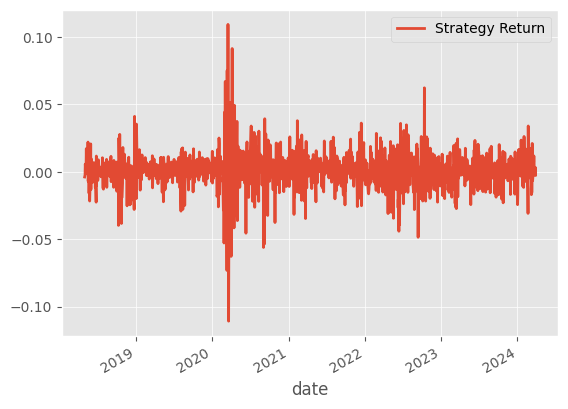

In [ ]:
portfolio_df.plot()

Now we have to compare to return of s&p 500

In [ ]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
2018-05-01        -0.003928      0.001775
2018-05-02        -0.002984     -0.006740
2018-05-03        -0.002474     -0.002206
2018-05-04         0.005639      0.012863
2018-05-07        -0.001313      0.003377
...                     ...           ...
2024-03-22        -0.000770     -0.001898
2024-03-25        -0.001821     -0.002767
2024-03-26        -0.002517     -0.001849
2024-03-27         0.003158      0.008369
2024-03-28        -0.002509     -0.000191

[1488 rows x 2 columns]

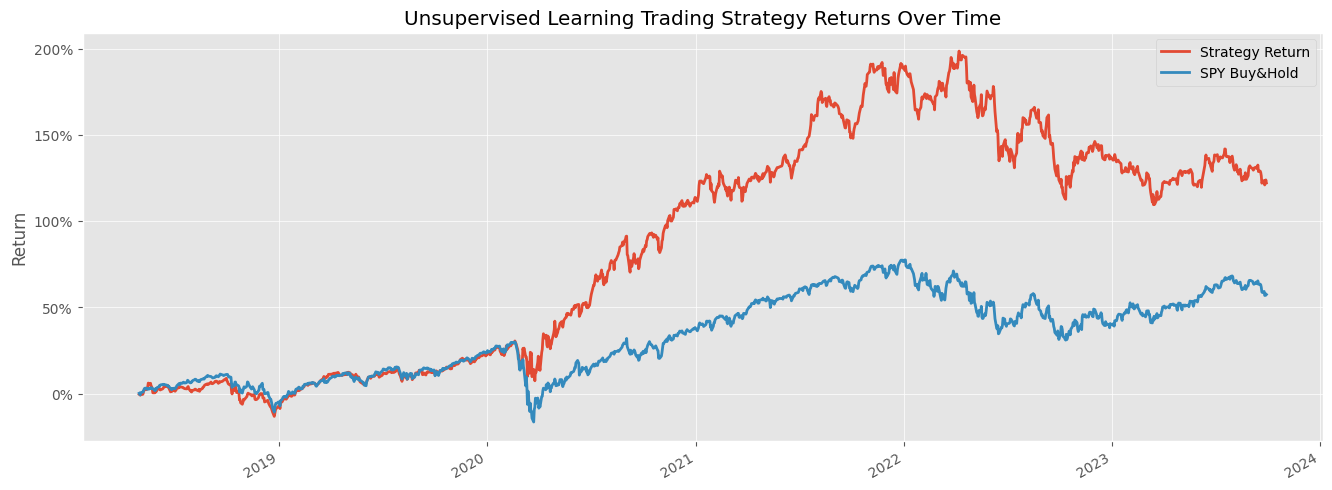

In [ ]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
